<h3>A simplified pipeline for the random forest classifier


In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats
from scipy.stats import randint as sp_randint 
from time import time
from operator import itemgetter


%matplotlib inline
os.getcwd()

'/home/ryan/Documents/insight_projects/steam_prices/data_analysis'

In [2]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

In [18]:
import pipeline as pl #contains the function for sorting the data

In [5]:
train_on = [14,15,16,17,18] #train on these epochs
for item in train_on:
    '''iterate through each of the epochs, extract the features and put them 
    all into a single X matrix and y vector'''
    cur_dat =  pl.sort_data(item)
    if item == train_on[0]:
        X = cur_dat['X']
        y = cur_dat['y']
    else:
        X = np.append(X,cur_dat['X'], axis = 0)
        y =  np.append(y,cur_dat['y'], axis = 0)

<h4>Peform cross validation and hyper-parameter tuning

In [6]:
clf = RF(n_estimators=20) #Random Forest Regression
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3,5,10, None],
              "max_features": sp_randint(1, 14),
              "min_samples_split": sp_randint(1, 14),
              "min_samples_leaf": sp_randint(1, 14),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 200
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv = 10)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)
best_params = random_search.best_params_

RandomizedSearchCV took 772.36 seconds for 200 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.966 (std: 0.004)
Parameters: {'bootstrap': True, 'min_samples_leaf': 2, 'min_samples_split': 6, 'criterion': 'entropy', 'max_features': 4, 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.966 (std: 0.004)
Parameters: {'bootstrap': True, 'min_samples_leaf': 8, 'min_samples_split': 6, 'criterion': 'gini', 'max_features': 3, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.966 (std: 0.004)
Parameters: {'bootstrap': True, 'min_samples_leaf': 11, 'min_samples_split': 11, 'criterion': 'gini', 'max_features': 4, 'max_depth': 10}



In [7]:
best_est = random_search.best_estimator_ #save the best estimator

<h4>Validation

In [8]:
'''pull out 19th epoch for the test set to use for validation (saved for this moment)'''
test_set =  pl.sort_data(19)

In [9]:
y_prediction = best_est.predict(test_set['Xall']) 

In [10]:
def accuracy(y_true,y_pred):
    # NumPy interprets True and False as 1. and 0.
    return np.mean(y_true == y_pred)

In [11]:
accuracy(test_set['yall'],y_prediction) #compare prediction with actual values

0.96252702378092725

<h4> Make confusion matrix

In [22]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


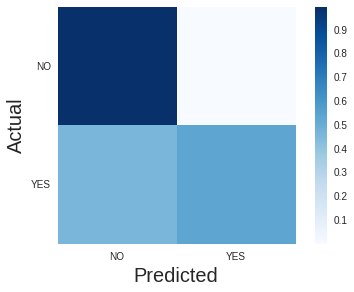

In [23]:
cm = confusion_matrix(test_set['yall'], y_prediction)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.xticks([1,0])
plt.yticks([0,1])
plt.gca().set_yticklabels(['NO','YES'])
plt.gca().set_xticklabels(['YES','NO'])
xlabel = ['Actual']
plt.xlabel('Predicted', fontsize = 20)
plt.ylabel('Actual',fontsize = 20)
plt.grid(False)
plt.title('')

In [24]:
'''report rate for each quadrant'''
cm_normalized

array([[ 1.  ,  0.  ],
       [ 0.46,  0.54]])